In [1]:
import uproot
import uproot_methods
import awkward
import matplotlib.pyplot as plt
import numpy as np
import time
import glob

In [2]:
files = glob.glob('/mnt/cms-data/store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/DYJetsToLL_M-50_HT-800to1200_TuneCP5_13TeV-madgraphMLM-pythia8/DYJetsToLLM-50HT-800to1200TuneCP513TeV-madgraphMLM-pythia8RunIIFall17MiniAODv2-PU2017/190312_200548/0000/*.root')

In [3]:
test = uproot.open("/mnt/cms-data/store/group/lpctlbsm/NanoAODJMAR_2019_V1/Production/CRAB/DYJetsToLL_M-50_HT-800to1200_TuneCP5_13TeV-madgraphMLM-pythia8/DYJetsToLLM-50HT-800to1200TuneCP513TeV-madgraphMLM-pythia8RunIIFall17MiniAODv2-PU2017/190312_200548/0000/nano102x_on_mini94x_2017_mc_NANO_8.root")['Events']

In [4]:
print( [i for i in test.keys() if b'Gen' in i] )

[b'nGenJetAK8', b'GenJetAK8_eta', b'GenJetAK8_mass', b'GenJetAK8_phi', b'GenJetAK8_pt', b'nGenJet', b'GenJet_eta', b'GenJet_mass', b'GenJet_phi', b'GenJet_pt', b'nGenPartAK8', b'GenPartAK8_eta', b'GenPartAK8_mass', b'GenPartAK8_phi', b'GenPartAK8_pt', b'GenPartAK8_charge', b'GenPartAK8_pdgId', b'nGenPart', b'GenPart_eta', b'GenPart_mass', b'GenPart_phi', b'GenPart_pt', b'GenPart_genPartIdxMother', b'GenPart_pdgId', b'GenPart_status', b'GenPart_statusFlags', b'nSubGenJetAK8', b'SubGenJetAK8_eta', b'SubGenJetAK8_mass', b'SubGenJetAK8_phi', b'SubGenJetAK8_pt', b'Generator_binvar', b'Generator_scalePDF', b'Generator_weight', b'Generator_x1', b'Generator_x2', b'Generator_xpdf1', b'Generator_xpdf2', b'Generator_id1', b'Generator_id2', b'nGenVisTau', b'GenVisTau_eta', b'GenVisTau_mass', b'GenVisTau_phi', b'GenVisTau_pt', b'GenVisTau_charge', b'GenVisTau_genPartIdxMother', b'GenVisTau_status', b'GenMET_phi', b'GenMET_pt', b'nGenDressedLepton', b'GenDressedLepton_eta', b'GenDressedLepton_mass',

In [6]:

jet_names = [b'FatJet_pt', b'FatJet_eta', b'FatJet_phi', b'FatJet_mass']
gen_names = [b'GenJetAK8_pt', b'GenJetAK8_eta', b'GenJetAK8_phi', b'GenJetAK8_mass']
#T = uproot.open("/uscms/home/rappocc/nobackup/analysis/B2G/CMSSW_10_2_9/src/Analysis/TTbarAllHad/test/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8_RunIIFall17NanoAODv4_example.root")["Events"]
rbins = [i * 0.01 for i in range(300)]
ptbins = [10,20,30,40,50,60,80,100,150,200,250,300,350,400,500,600,700,800,900,1000]
hists = []
start_time = time.perf_counter()
nev = 0
for T in uproot.iterate(files, 'Events', jet_names + gen_names, entrysteps=10000):

    Jet_pt,Jet_eta,Jet_phi,Jet_mass = [ T[i] for i in jet_names]
    GenJet_pt,GenJet_eta,GenJet_phi,GenJet_mass = [ T[i] for i in gen_names]


    jets = uproot_methods.TLorentzVectorArray.from_ptetaphim(Jet_pt, Jet_eta, Jet_phi, Jet_mass)
    genjets = uproot_methods.TLorentzVectorArray.from_ptetaphim(GenJet_pt, GenJet_eta, GenJet_phi, GenJet_mass)
    
    
    goodjets_index = jets.pt > 30.
    goodgens_index = genjets.pt > 10.
    goodjets = jets[goodjets_index]
    goodgens = genjets[goodgens_index]    
    
    pairing = goodjets.cross(goodgens, nested=True)
    metric = pairing.i0.delta_r(pairing.i1)
    index_of_minimized = metric.argmin()
    passes_cut = (metric[index_of_minimized] < 0.4)
    best_pairings_that_pass_cut = pairing[index_of_minimized][passes_cut]
    genrecos = best_pairings_that_pass_cut.flatten(axis=1)
    

    ptresponse = genrecos.i0.pt / genrecos.i1.pt
    H,xedges,yedges=np.histogram2d(x=genrecos.i1.pt.flatten(), y=ptresponse.flatten(), bins=[ptbins,rbins])
    hists.append(H)
    nev += 1
    
cpu_time = time.perf_counter() - start_time
print ('Processing time: ', cpu_time, ',  nev: ', nev) 

Processing time:  162.54620751499988 ,  nev:  329


In [7]:
# Set fonts (from https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


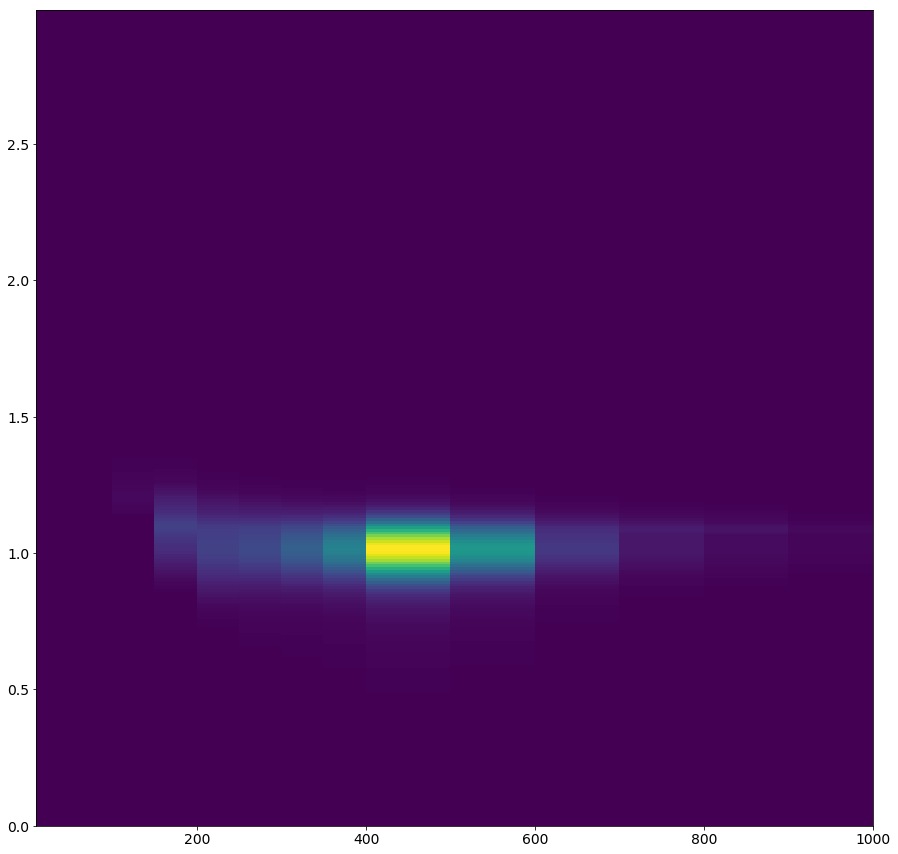

In [9]:
hist = sum( hists )
X,Y=np.meshgrid(xedges,yedges)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, hist.T)